[映画レビューのテキスト分類  \|  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/text_classification?hl=ja)

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.1.0


IMDB datasetのダウンロード

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


### データの観察

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


データセットは前処理済み

- データ : 映画レビューの中の単語を表す整数の配列
- ラベル : 0が否定的レビュー、1が肯定的なレビュー

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


映画のレビューはそれぞれ長さが異なっている点に注意

In [5]:
len(train_data[0]), len(train_data[1]), len(train_data[2])

(218, 189, 141)

### 整数を単語に戻す

In [6]:
# 単語を整数にマッピングする辞書
word_index = imdb.get_word_index()

# インデックスの最初の方は予約済み
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


`decode_review`を使うと、最初のレビューのテキストを表示できる

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### データの準備

レビュー（整数の配列）は、ニューラルネットワークに投入する前に、テンソルに変換する

配列をパディングによって同じ長さに揃え、`サンプル数 * 長さの最大値`の形の整数テンソルにします。そして、この形式を扱うことができるEmbedding（埋め込み）層をネットワークの最初の層にする

長さを標準化する`pad_sequences`関数を使う

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

これにより、入力データの長さが統一される

In [9]:
len(train_data[0]), len(train_data[1]), len(train_data[2])

(256, 256, 256)

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### モデルの構築

1. 埋め込み層 (Embedding) : 整数にエンコードされた語彙を受け取り、それぞれの単語インデックスに対応する埋め込みベクトルを検索する。ベクトル化のために、出力行列には次元が１つ追加される
2. １次元のグローバル平均プーリング層 (GlobalAveragePooling1D) : シーケンスの次元方向に平均値をもとめ、固定長のベクトルを返す。可変長の入力を扱うことができる
3. 全結合層 (Dense) : 16個の隠れユニットを持つ全結合層
4. 全結合層 (Dense) : 1個の出力ノードに全結合する。sigmoid活性化関数を使うことで出力は確率を表す

In [11]:
# 入力の形式は映画レビューで使われている語彙数（10,000語）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### モデルのコンパイル

- 最適化手法 : adam
- 損失関数 : 例えば `mean_squared_error` （平均二乗誤差）を使うこともできるが、一般的には、確率を扱うときは `binary_crossentropy` の方が適している
- 指標 : accuracy (精度)

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### チューニングのために検証用データを作る

モデルのパラメータのチューニングには、テスト用データを使わずに、検証用データを使う

In [13]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### モデルの訓練

512個のサンプルからなるミニバッチを使って、40エポックモデルを訓練する

訓練中、検証用データの10,000サンプルを用いて、モデルの損失と正解率をモニタリングする

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 100us/sample - loss: 0.6921 - accuracy: 0.5733 - val_loss: 0.6902 - val_accuracy: 0.6700
Epoch 2/40
15000/15000 [==============================] - 1s 39us/sample - loss: 0.6872 - accuracy: 0.7340 - val_loss: 0.6839 - val_accuracy: 0.7108
Epoch 3/40
15000/15000 [==============================] - 1s 39us/sample - loss: 0.6781 - accuracy: 0.7302 - val_loss: 0.6727 - val_accuracy: 0.7300
Epoch 4/40
15000/15000 [==============================] - 1s 39us/sample - loss: 0.6626 - accuracy: 0.7544 - val_loss: 0.6547 - val_accuracy: 0.7473
Epoch 5/40
15000/15000 [==============================] - 1s 40us/sample - loss: 0.6392 - accuracy: 0.7755 - val_loss: 0.6294 - val_accuracy: 0.7486
Epoch 6/40
15000/15000 [==============================] - 1s 39us/sample - loss: 0.6083 - accuracy: 0.7859 - val_loss: 0.5979 - val_accuracy: 0.7771
Epoch 7/40
15000/15000 [==============================]

### モデルの評価

損失と正解率（今回の結果では87%前後の正解率）

In [15]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

25000/25000 - 1s - loss: 0.3166 - accuracy: 0.8747
[0.3165797951841354, 0.87468]


### 正解率と損失の時系列グラフを描く

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

訓練時と検証時の損失を比較するグラフと、訓練時と検証時の正解率を比較するグラフを作成する

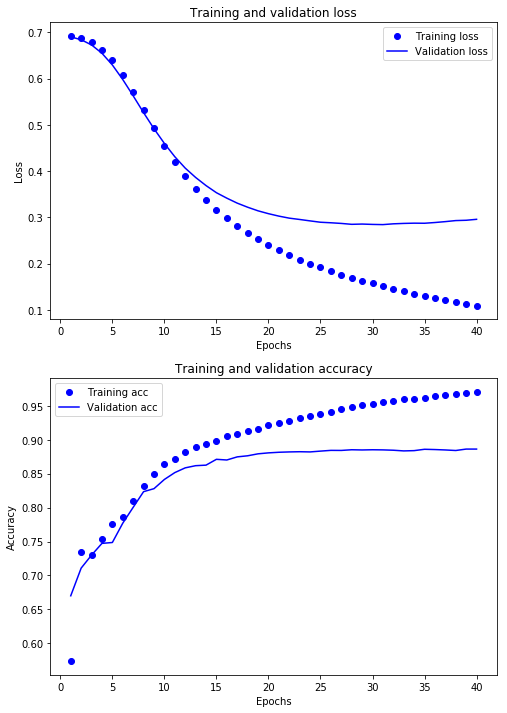

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 12))

plt.subplot(2,1,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# "b" is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

訓練時の損失がエポックごとに減少し、訓練時の正解率がエポックごとに上昇している。しかし、20エポックを過ぎたあたりから横ばいになっている。これが過学習の一例である。

このケースの場合、20エポックを過ぎたあたりで訓練をやめることで、過学習を防止することが出来る。